In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import kruskal
from sklearn.manifold import TSNE

In [2]:
!dir ashrae-energy-prediction

 Volume in drive C is OS
 Volume Serial Number is 3E0C-6C0C

 Directory of C:\Users\johns\Desktop\probstats2\EnergyPrediction-ASHRAE\code\ashrae-energy-prediction

03/05/2023  05:52 PM    <DIR>          .
03/05/2023  05:52 PM    <DIR>          ..
03/05/2023  05:52 PM            45,527 building_metadata.csv
03/05/2023  05:52 PM       447,562,511 sample_submission.csv
03/05/2023  05:52 PM     1,462,461,085 test.csv
03/05/2023  05:52 PM       678,616,640 train.csv
03/05/2023  05:52 PM        14,787,908 weather_test.csv
03/05/2023  05:52 PM         7,450,075 weather_train.csv
               6 File(s)  2,610,923,746 bytes
               2 Dir(s)  95,487,418,368 bytes free


# Load and Merge Data 
This code assumes that the data folder is located in the same directory as the notebook

In [3]:
building = pd.read_csv("./ashrae-energy-prediction/building_metadata.csv")
train = pd.read_csv("./ashrae-energy-prediction/train.csv")
weather_train = pd.read_csv("./ashrae-energy-prediction/weather_train.csv")

In [4]:
building.describe()

,site_id,building_id,square_feet,year_built,floor_count
count,1449.000000,1449.000000,1449.000000,675.000000,355.000000
mean,6.952381,724.000000,92111.776398,1967.957037,3.740845
std,5.003432,418.434583,110769.950997,31.054030,3.333683
min,0.000000,0.000000,283.000000,1900.000000,1.000000
25%,3.000000,362.000000,23012.000000,1949.000000,1.000000
50%,5.000000,724.000000,57673.000000,1970.000000,3.000000
75%,13.000000,1086.000000,115676.000000,1995.000000,5.000000
max,15.000000,1448.000000,875000.000000,2017.000000,26.000000


In [5]:
train.describe()

,building_id,meter,meter_reading
count,2.021610e+07,2.021610e+07,2.021610e+07
mean,7.992780e+02,6.624412e-01,2.117121e+03
std,4.269133e+02,9.309921e-01,1.532356e+05
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.930000e+02,0.000000e+00,1.830000e+01
50%,8.950000e+02,0.000000e+00,7.877500e+01
75%,1.179000e+03,1.000000e+00,2.679840e+02
max,1.448000e+03,3.000000e+00,2.190470e+07


In [6]:
weather_train.describe()

,site_id,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
count,139773.000000,139718.000000,70600.000000,139660.000000,89484.000000,129155.000000,133505.000000,139469.000000
mean,7.478977,14.418106,2.149306,7.350158,0.983047,1016.158038,180.526632,3.560527
std,4.604744,10.626595,2.599150,9.790235,8.463678,7.629684,111.523629,2.335874
min,0.000000,-28.900000,0.000000,-35.000000,-1.000000,968.200000,0.000000,0.000000
25%,3.000000,7.200000,0.000000,0.600000,0.000000,1011.800000,80.000000,2.100000
50%,7.000000,15.000000,2.000000,8.300000,0.000000,1016.400000,190.000000,3.100000
75%,11.000000,22.200000,4.000000,14.400000,0.000000,1020.800000,280.000000,5.000000
max,15.000000,47.200000,9.000000,26.100000,343.000000,1045.500000,360.000000,19.000000


In [7]:
df = building 
df = df.merge(train, on='building_id', how='left')
df = df.merge(weather_train, on=['site_id', 'timestamp'], how='left')

C:\Users\johns\AppData\Local\Temp\ipykernel_8224\1929374606.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr())


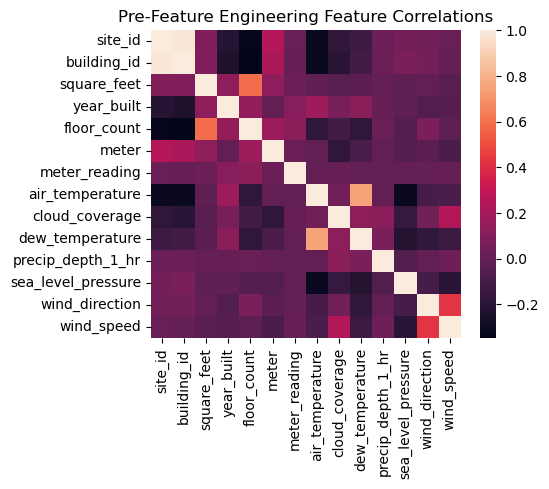

In [8]:
plt.figure(figsize=(5,4))
sns.heatmap(df.corr())
plt.title("Pre-Feature Engineering Feature Correlations")
plt.show()

# Basic Feature Engineering / Manipulation

In [9]:
df['log_meter_reading'] = np.log(df['meter_reading'])
df['log_square_feet'] = np.log(df['square_feet'])
df['log_precip_depth_1_hr'] = np.log(df['precip_depth_1_hr'])

# Fill any infinity values with zero 
df['log_meter_reading'].replace([np.inf, -np.inf, np.nan], 0, inplace=True)
df['log_square_feet'].replace([np.inf, -np.inf, np.nan], 0, inplace=True)
df['log_precip_depth_1_hr'].replace([np.inf, -np.inf, np.nan], 0, inplace=True)

# Get time (granular down to the hour, and only one year)
df['timestamp'] = pd.to_datetime(df['timestamp']) 
df['hour'] = df['timestamp'].dt.hour
df['day'] = df['timestamp'].dt.day
df['month'] = df['timestamp'].dt.month
df['weekday'] = df['timestamp'].dt.dayofweek

# Map meter values to their true name 
df['meter'] = df['meter'].replace({
    0: 'electricity',
    1: 'chilledwater',
    2: 'steam',
    3: 'hotwater'
})

C:\Users\johns\anaconda3\envs\probstats\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\johns\anaconda3\envs\probstats\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\johns\anaconda3\envs\probstats\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Skipping primary_use
Skipping meter
Skipping timestamp


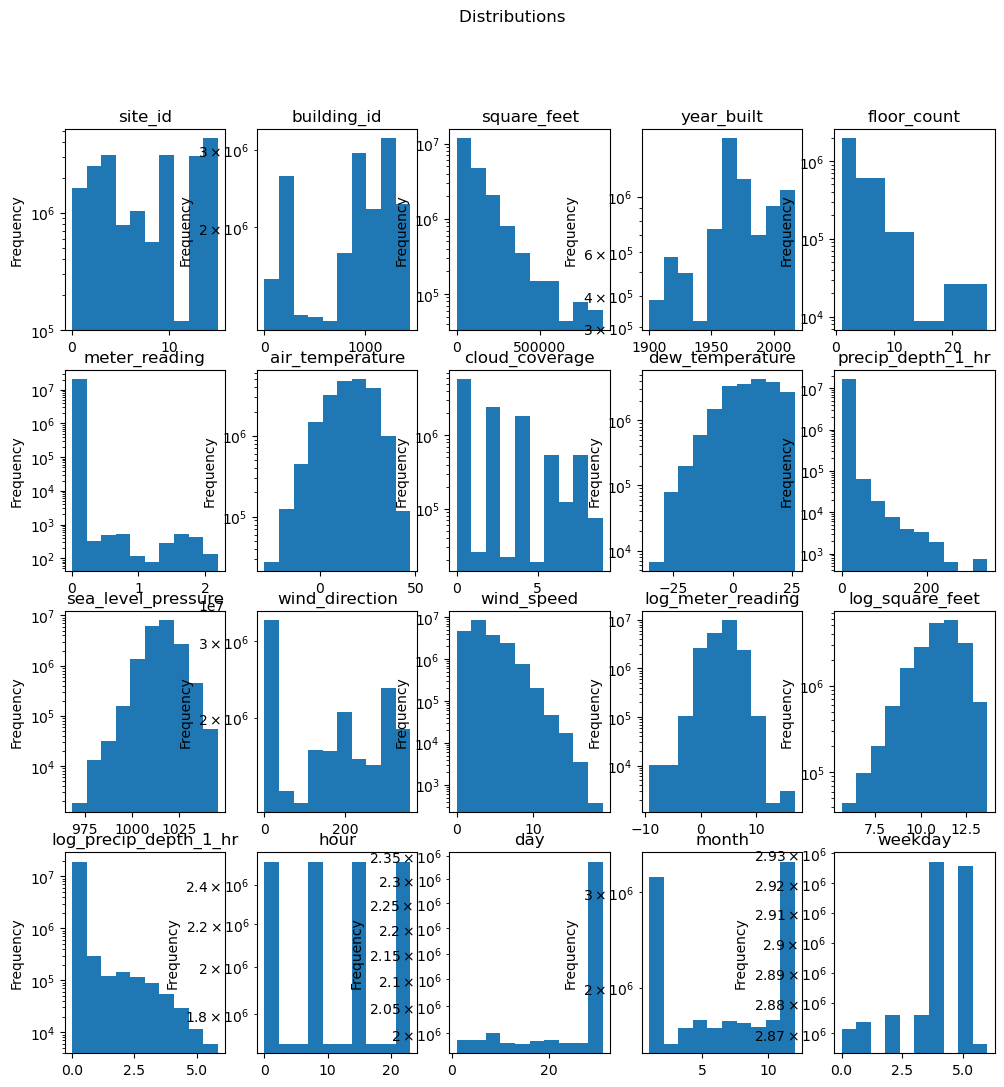

In [10]:
fig, axes = plt.subplots(4,5, figsize=(12,12))

# Generate a histogram for each feature 
i = 0
for feat in df.columns:
    try:
        sub_axis = axes[i // 5][i % 5]
        df[feat].plot.hist(ax=sub_axis)
        sub_axis.set_yscale('log')
        sub_axis.set_title(feat)
        
        i += 1 
    except:
        print(f"Skipping {feat}")
       

plt.suptitle("Distributions ")
plt.show()

# Hypothesis Testing 
Given the non-Gaussian nature of the data, I conducted parametric tests to observe the data

In [ ]:
# Compare metrics across building IDs 
for feature in df.columns:
    _, pval = kruskal(
        *[df[df['building_id'] == sid][feature].dropna() for sid in df['building_id'].unique()]
    )
    print(feature, pval)

site_id 0.0
building_id 0.0


In [ ]:
# data isn't necessarily linear, observe it with T-SNE
for meter in df['meter'].unique():
    data = df[df['meter'] == meter]
    tsne = TSNE(n_jobs=4)
    transformed_df = tsne.fit_transform(data)
    plt.scatter(transformed_df[:,0], transformed_df[:,1], c=data['building_id'], cmap='viridis')
    plt.title(f"TSNE {meter}")
    plt.colorbar()
    plt.show()